## This notebook aims at predicting the daily **Arctic sea ice extent** using a Sequential Deep Learning model.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("SIE (Million Km$^2$)")
    plt.grid(True)

Retrieve the data from the NOAA public ftp. Note that the file is updated daily.

In [3]:
!wget --no-check-certificate \
    ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv \
    -O /tmp/daily_sie.csv

--2020-10-27 09:39:33--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv
           => ‘/tmp/daily_sie.csv’
Resolving sidads.colorado.edu (sidads.colorado.edu)... 128.138.135.20
Connecting to sidads.colorado.edu (sidads.colorado.edu)|128.138.135.20|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /DATASETS/NOAA/G02135/north/daily/data ... done.
==> SIZE N_seaice_extent_daily_v3.0.csv ... 1557636
==> PASV ... done.    ==> RETR N_seaice_extent_daily_v3.0.csv ... done.
Length: 1557636 (1.5M) (unauthoritative)

N_seaice_extent_dai 100%[===================>]   1.49M   349KB/s    in 4.4s    

2020-10-27 09:39:39 (349 KB/s) - ‘/tmp/daily_sie.csv’ saved [1557636]



In [4]:
df = pd.read_csv('/tmp/daily_sie.csv', usecols=range(4), skiprows=0) # Start: Nov 1st 1978

df_copy = df.copy()
df = df.iloc[4:]
df = df.astype(float)

# Remove blank spaces in column titles
df.columns = df.columns.to_series().apply(lambda x: x.strip()) 
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

df = df.set_index(['Date'])

Select from September 1987 (when records started daily) to August 2020 

In [5]:
sie_198709_202008 = df.loc['1987-09-01':'2020-08-31']['Extent']

In [6]:
series_sie = np.array(sie_198709_202008)
time1 = np.array(sie_198709_202008.index)
timex = np.array(range(0, series_sie.size))

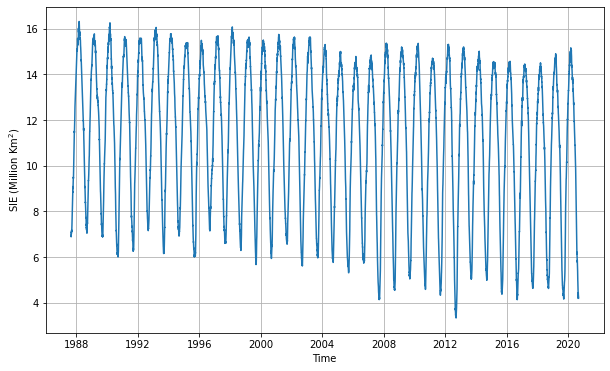

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time1, series_sie)

In [8]:
split_time = 10000
time_train = timex[:split_time]
x_train = series_sie[:split_time]
time_valid = timex[split_time:]
x_valid = series_sie[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

The previous values (window or input) will determine the following labels (or target):

1) Create a Tensorflow Dataset instance with series values.

2) The data is split into chunks of window_size items shifted by one value each. This arranges the data in a tabular format. The parameter drop_remainder ensures that all rows in the data window are the same length by cropping data.

3) The data is flattened.

4) Next is to split the data into Xs and Ys; that's features and labels.

5) The data is shuffled. Features and labels are shuffled correspondingly.

6) We train our model by sending data in batches.


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(10000,)
Epoch 1/100
39/39 [==============================] - 1s 38ms/step - loss: 32.2013 - mae: 32.6981
Epoch 2/100
39/39 [==============================] - 2s 39ms/step - loss: 27.9635 - mae: 28.4594
Epoch 3/100
39/39 [==============================] - 2s 39ms/step - loss: 19.7184 - mae: 20.2160
Epoch 4/100
39/39 [==============================] - 1s 38ms/step - loss: 9.2883 - mae: 9.7742
Epoch 5/100
39/39 [==============================] - 1s 38ms/step - loss: 4.2707 - mae: 4.7544
Epoch 6/100
39/39 [==============================] - 2s 39ms/step - loss: 3.3682 - mae: 3.8503
Epoch 7/100
39/39 [==============================] - 2s 39ms/step - loss: 2.7954 - mae: 3.2677
Epoch 8/100
39/39 [==============================] - 2s 39ms/step - loss: 2.3835 - mae: 2.8412
Epoch 9/100
39/39 [==============================] - 2s 39ms/step - loss: 2.1043 - mae: 2.5472
Epoch 10/100
39/39 [================

Check the optimal loss (which is actually close to $10^{-6}$):


(1e-08, 0.0001, 0.0, 60.0)

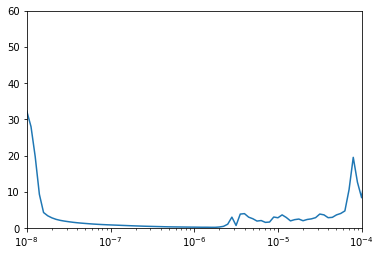

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Re-run the model with the optimal loss. Note that some parameters are changed with respect to the previous version (number of filters, LSTM size, epochs, batch and window size):

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=150)

Epoch 1/150
100/100 [==============================] - 2s 16ms/step - loss: 5.9934 - mae: 6.4739
Epoch 2/150
100/100 [==============================] - 2s 16ms/step - loss: 3.8583 - mae: 4.3444
Epoch 3/150
100/100 [==============================] - 2s 16ms/step - loss: 1.8568 - mae: 2.3089
Epoch 4/150
100/100 [==============================] - 2s 17ms/step - loss: 0.1832 - mae: 0.4527
Epoch 5/150
100/100 [==============================] - 2s 17ms/step - loss: 0.1254 - mae: 0.3549
Epoch 6/150
100/100 [==============================] - 2s 17ms/step - loss: 0.1002 - mae: 0.3106
Epoch 7/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0786 - mae: 0.2561
Epoch 8/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0900 - mae: 0.2977
Epoch 9/150
100/100 [==============================] - 2s 17ms/step - loss: 0.0774 - mae: 0.2620
Epoch 10/150
100/100 [==============================] - 2s 16ms/step - loss: 0.0656 - mae: 0.2271
Epoch 11/150
100/100 [=======

Evaluation of the loss and the MAE:

<Figure size 432x288 with 0 Axes>

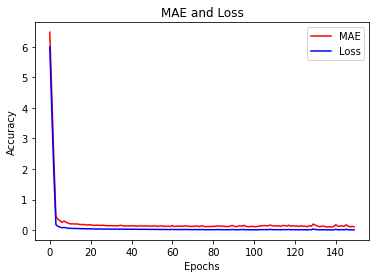

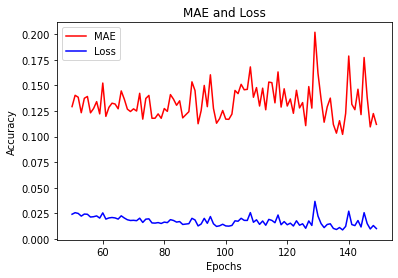

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = mae[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

Make the forecast for the validation data:

In [15]:
# split_time = 1000; window_size = 64; series_sie.shape = (12013, ); series_sie[..., np.newaxis].shape = (12013, 1)

rnn_forecast = model_forecast(model, series_sie[..., np.newaxis], window_size) # rnn_forecast.shape = (11950, 64, 1) # 11950 --> series_sie.shape - window_size + 1 
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0] # rnn_forecast.shape = (2013, ) --> As x_valid

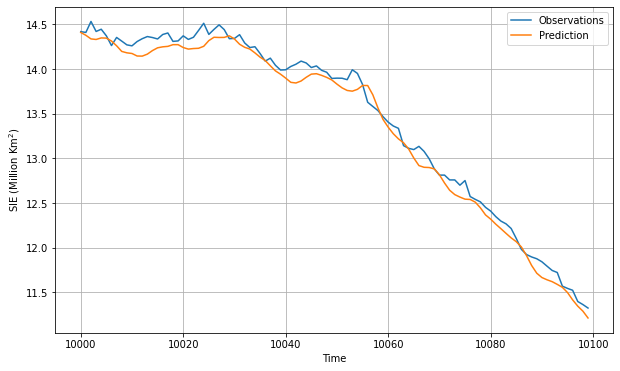

In [78]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[:100], x_valid[:100])
plot_series(time_valid[:100], rnn_forecast[:100])
plt.legend(['Observations', 'Prediction'])

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.111906745

In [19]:
print(rnn_forecast)

[14.409704  14.37819   14.337561  ...  4.197073   4.2017317  4.179027 ]


Let's predict another more recent period:

In [20]:
sie_202009 = df.loc['2020-09-01':'2020-09-30']['Extent']
series_sep = np.array(sie_202009)
time2 = np.array(sie_202009.index)
timey = np.array(range(0, series_sep.size))

In [74]:
forecast2 = model_forecast(model, series_sep[..., np.newaxis], window_size=10) # Increasing the window, decreases the forecast range we can do
forecast2 = forecast2[:-1, -1, 0]

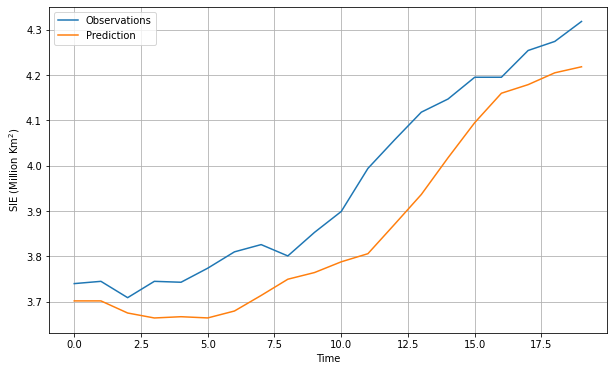

In [77]:
plt.figure(figsize=(10, 6))
plot_series(range(0,20), series_sep[10:])
plot_series(range(0,20), forecast2)
plt.legend(['Observations', 'Prediction'])


In [76]:
tf.keras.metrics.mean_absolute_error(series_sep[10:], forecast2).numpy()

0.09700135



---

